In [1]:
import jax.numpy as jnp

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-jnp.pi, jnp.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

C:\Users\Yudi\AppData\Local\Temp\ipykernel_1980\1909444407.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [3]:
key = random.PRNGKey(10)

train_points = 20
test_points = 100
noise_scale = 1e-1

target_fn = lambda x: jnp.sin(x)


key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-jnp.pi, maxval=jnp.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)


test_xs = jnp.linspace(-jnp.pi, jnp.pi, test_points)
test_xs = jnp.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

In [4]:
from typing import Optional
def _affine(
    mat: Optional[jnp.ndarray],
    W_std: float,
    b_std: Optional[float],
) -> Optional[jnp.ndarray]:
  """Get covariances of affine outputs if inputs have covariances `nngp`.

  The output is assumed to be `xW + b`, where `x` is the input, `W` is a matrix
  of i.i.d. Gaussian weights with std `W_std`, `b` is a vector of i.i.d.
  Gaussian biases with std `b_std`.

  Args:
    mat:
      a `jnp.ndarray` containing sample-[sample-]position[-position] covariances
      of inputs.

    W_std:
      standard deviation of a fully-connected layer weights.

    b_std:
      standard deviation of a fully-connected layer biases.
      `None` means no bias.

  Returns:
    a `jnp.ndarray` containing sample-[sample-]position[-position] covariances
    of FC outputs. Has the same shape as `nngp`.
  """
  if mat is not None:
    mat *= W_std**2

    if b_std is not None:
      mat += b_std**2

  return mat

def Dense(
    out_dim: int,
    W_std: float = 1.,
    b_std: Optional[float] = None,
    batch_axis: int = 0,
    channel_axis: int = -1,
    parameterization: str = 'test'
):
  r"""Dense (fully-connected, matrix product).

  Based on :obj:`jax.example_libraries.stax.Dense`.

  Args:
    out_dim:
      The output feature / channel dimension. This is ignored in by the
      `kernel_fn` in `"ntk"` parameterization.

    W_std:
      Specifies the standard deviation of the weights.

    b_std:
      Specifies the standard deviation of the biases. `None` means no bias.

    batch_axis:
      Specifies which axis is contains different elements of the batch.
      Defaults to `0`, the leading axis.

    channel_axis: Specifies which axis contains the features / channels.
      Defaults to `-1`, the trailing axis. For `kernel_fn`, channel size is
      considered to be infinite.

    parameterization:
      Either `"ntk"` or `"standard"`.

      Under `"ntk"` parameterization (page 3 in "`Neural Tangent Kernel:
      Convergence and Generalization in Neural Networks
      <https://arxiv.org/abs/1806.07572>`_"),
      weights and biases are initialized as
      :math:`W_{ij} \sim \mathcal{N}(0,1)`, :math:`b_i \sim \mathcal{N}(0,1)`,
      and the finite width layer equation is
      :math:`z_i = \sigma_W / \sqrt{N} \sum_j W_{ij} x_j + \sigma_b b_i`, where
      `N` is `out_dim`.

  Returns:
    `(init_fn, apply_fn, kernel_fn)`.
  """
  # TODO(jaschasd): after experimentation, evaluate whether to change default
  # parameterization from "ntk" to "standard"

  parameterization = parameterization.lower()

  def _init_fn(rng, input_shape, out_dim):
    _channel_axis = channel_axis % len(input_shape)
    output_shape = (input_shape[:_channel_axis] + (out_dim,)
                    + input_shape[_channel_axis + 1:])
    rng1, rng2 = random.split(rng)
    W = random.normal(rng1, (input_shape[_channel_axis], out_dim))

    if b_std is None:
      b = None
    else:
      b_shape = [1] * len(input_shape)
      b_shape[channel_axis] = out_dim
      b = random.normal(rng2, b_shape)

    return output_shape, (W, b)

  def ntk_init_fn(rng, input_shape):
    return _init_fn(rng, input_shape, out_dim)

  def standard_init_fn(rng, input_shape):
    output_shape, (W, b) = _init_fn(rng, input_shape, out_dim)
    W *= W_std / input_shape[channel_axis]**0.5
    b = None if b is None else b * b_std
    return output_shape, (W, b)
      
  def test_init_fn(rng, input_shape):
    return _init_fn(rng, input_shape, out_dim)

  if parameterization == 'ntk':
    init_fn = ntk_init_fn
  elif parameterization == 'standard':
    init_fn = standard_init_fn
  elif parameterization == 'test':
    init_fn = test_init_fn
  else:
    raise ValueError(f'Parameterization not supported: {parameterization}')

  def apply_fn(params, inputs, **kwargs):
    W, b = params
    prod = jnp.moveaxis(jnp.tensordot(W, inputs, (0, channel_axis)), 0, channel_axis)
    if parameterization == 'ntk':
      # scaling = jnp.ones(inputs.shape[channel_axis]) / inputs.shape[channel_axis]**0.5
      # Wscaled = W * scaling[:, None]
      # prod = jnp.moveaxis(jnp.tensordot(Wscaled, inputs, (0, channel_axis)), 0, channel_axis)

      scaling = W_std / inputs.shape[channel_axis]**0.5
      outputs = scaling * prod
      if b is not None:
        outputs += b_std * b
    elif parameterization == 'standard':
      outputs = prod
      if b is not None:
        outputs += b
    elif parameterization == 'test':
      scaling = 1 / ( jnp.sum(1/jnp.arange(1, inputs.shape[channel_axis]+1)) * jnp.arange(1, inputs.shape[channel_axis]+1) )**0.5
      Wscaled = W * scaling[:, None]
      outputs = W_std * prod
      if b is not None:
        outputs += b_std * b
    else:
      raise ValueError(f'Parameterization not supported: {parameterization}')

    return outputs

  def kernel_fn(k, **kwargs):
    """Compute the transformed kernels after a `Dense` layer."""
    cov1, nngp, cov2, ntk = k.cov1, k.nngp, k.cov2, k.ntk

    def fc(x):
      return _affine(x, W_std, b_std)

    if parameterization == 'ntk':
      cov1, nngp, cov2 = map(fc, (cov1, nngp, cov2))
      if ntk is not None:
        ntk = nngp + W_std**2 * ntk
    elif parameterization == 'standard':
      input_width = k.shape1[channel_axis]
      if ntk is not None:
        ntk = input_width * nngp + W_std**2 * ntk
        if b_std is not None:
          ntk += 1.
      cov1, nngp, cov2 = map(fc, (cov1, nngp, cov2))
    elif parameterization == 'test':
      cov1, nngp, cov2 = map(fc, (cov1, nngp, cov2))
      if ntk is not None:
        ntk = nngp + W_std**2 * ntk

    return k.replace(cov1=cov1,
                     nngp=nngp,
                     cov2=cov2,
                     ntk=ntk,
                     is_gaussian=True,
                     is_input=False)

  return init_fn, apply_fn, kernel_fn

In [5]:
init_fn, apply_fn, kernel_fn = stax.serial(
    Dense(512, W_std=1, b_std=0.1, parameterization='ntk'), stax.Erf(),
    Dense(512, W_std=1, b_std=0.1, parameterization='ntk'), stax.Erf(),
    Dense(1, W_std=1, b_std=0.1, parameterization='ntk')
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

In [6]:
def train_network(key): #wrapping up a neural network
  train_losses = []
  test_losses = []

  _, params = init_fn(key, (-1, 1))
  opt_state = opt_init(params)

  for i in tqdm(range(training_steps)):
    train_losses += [jnp.reshape(loss(get_params(opt_state), *train), (1,))]
    test_losses += [jnp.reshape(loss(get_params(opt_state), *test), (1,))]
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses = jnp.concatenate(train_losses)
  test_losses = jnp.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

In [7]:
learning_rate = 0.1
ts = jnp.arange(0, 10000*learning_rate, learning_rate)
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

loss = jit(lambda params, x, y: 0.5 * jnp.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

params, train_loss, test_loss = train_network(key)

100%|██████████| 10000/10000 [00:19<00:00, 522.68it/s]


NTK-GP

In [8]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = jnp.reshape(mean, mean.shape[:1] + (-1,))
  var = jnp.diagonal(cov, axis1=1, axis2=2)
  ys = jnp.reshape(ys, (1, -1))

  mean_predictions = 0.5 * jnp.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

In [9]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, train_ys, diag_reg=1e-4)
ntk_mean, ntk_var = predict_fn(x_test=test_xs, get='ntk', compute_cov=True)

ntk_mean = jnp.reshape(ntk_mean, (-1,))
ntk_std = jnp.sqrt(jnp.diag(ntk_var))

ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

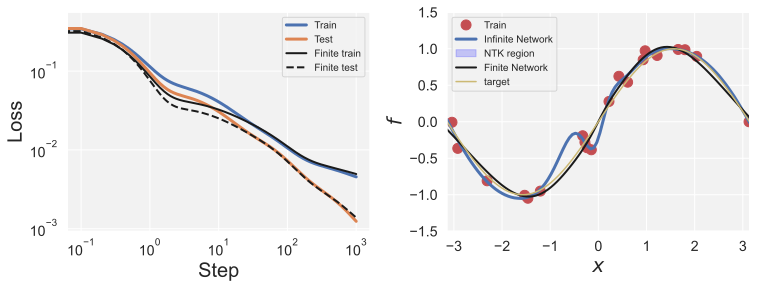

In [10]:
# test {"skip": true}
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k--', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 
        'Finite train', 'Finite test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(params, test_xs), 'k-', linewidth=2)
plt.plot(test_xs, jnp.sin(test_xs), 'y-')

legend(['Train', 'Infinite Network', 'NTK region', 'Finite Network', 'target'], loc='upper left')

finalize_plot((1.5, 0.6))

In [11]:
import torch
import torch.nn as nn
from torch.func import functional_call, vmap, vjp, jvp, jacrev
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

import numpy as np

In [12]:
class Network(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = 512
        self.output_dim = 1

        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.layer3 = nn.Linear(self.hidden_dim, self.output_dim)

        self._ntk_init()

    def _ntk_init(self):
        for layer in [self.layer1, self.layer2, self.layer3]:
            # Weight initialization
            nn.init.normal_(layer.weight, mean=0.0, std=1/np.sqrt(self.hidden_dim))
            
            # Bias initialization
            nn.init.normal_(layer.bias, mean=0.0, std=0.1)

    def erf(self, x):
        return torch.erf(x)

    def forward(self, x):
        x = self.erf(self.layer1(x))
        x = self.erf(self.layer2(x))
        x = self.layer3(x)
        return x

model = Network(1).to(device)

In [13]:
train_x = torch.FloatTensor(np.array(train_xs)).to(device)
train_y = torch.FloatTensor(np.array(train_ys)).to(device)
test_x = torch.FloatTensor(np.array(test_xs)).to(device)
test_y = torch.FloatTensor(np.array(test_ys)).to(device)

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_data, batch_size=train_x.shape[0])
test_loader = DataLoader(test_data, batch_size=test_x.shape[0])

In [14]:
def test_model(model, data_loader):
    model.eval()
    total_loss, count = 0, 0
    for x, y in data_loader:
        with torch.no_grad():
            preds = model(x).view_as(y)
            loss = criterion(preds, y)
            total_loss += loss.item()
    return total_loss

In [15]:
learning_rate = 0.1/np.sqrt(512)
epochs = 10000

criterion = nn.MSELoss()

optimizer = SGD(model.parameters(), lr=learning_rate)

train_scores = []
val_scores = []

for epoch in tqdm(range(epochs)):
    model.train()

    epoch_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x).view_as(y)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_scores.append(epoch_loss)

    val_loss = test_model(model, test_loader)
    val_scores.append(val_loss)

test_loss = test_model(model, test_loader)

100%|██████████| 10000/10000 [00:20<00:00, 477.19it/s]


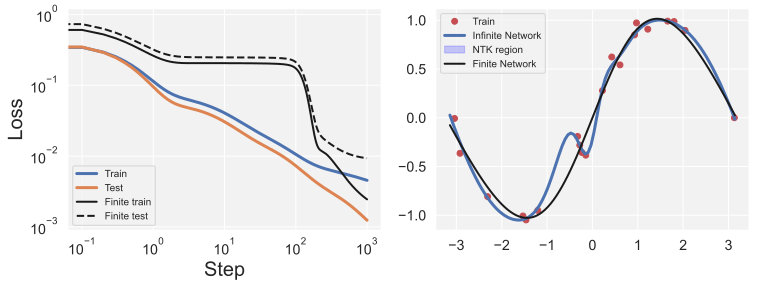

In [16]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, val_scores, 'k-', linewidth=2)
plt.loglog(ts, train_scores, 'k--', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 
        'Finite train', 'Finite test'])

plt.subplot(1, 2, 2)

plt.plot(train_xs, train_ys, 'ro')

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, model(test_x).cpu().detach().numpy(), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'NTK region', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [17]:
import math
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F, init

In [18]:
class NTKLinear(nn.Module):
    r"""Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`.

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_\text{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_\text{in} = \text{in\_features}`.
        - Output: :math:`(*, H_\text{out})` where all but the last dimension
          are the same shape as the input and :math:`H_\text{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """

    __constants__ = ["in_features", "out_features"]
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(
            torch.empty((out_features, in_features), **factory_kwargs)
        )
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight/np.sqrt(self.in_features), 0.1*self.bias)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"

In [19]:
class Network2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = 512
        self.output_dim = 1

        self.layer1 = NTKLinear(self.input_dim, self.hidden_dim)
        self.layer2 = NTKLinear(self.hidden_dim, self.hidden_dim)
        self.layer3 = NTKLinear(self.hidden_dim, self.output_dim)

        self._ntk_init()

    def _ntk_init(self):
        for layer in [self.layer1, self.layer2, self.layer3]:
            # Weight initialization
            nn.init.normal_(layer.weight, mean=0.0, std=1)
            
            # Bias initialization
            nn.init.normal_(layer.bias, mean=0.0, std=1)

    def erf(self, x):
        return torch.erf(x)

    def forward(self, x):
        x = self.erf(self.layer1(x))
        x = self.erf(self.layer2(x))
        x = self.layer3(x)
        return x

model2 = Network2(1).to(device)

In [20]:
learning_rate = 0.1
epochs = 10000

criterion = nn.MSELoss()

optimizer = SGD(model2.parameters(), lr=learning_rate)

train_scores = []
val_scores = []

for epoch in tqdm(range(epochs)):
    model.train()

    epoch_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model2(x).view_as(y)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_scores.append(epoch_loss)

    val_loss = test_model(model2, test_loader)
    val_scores.append(val_loss)

test_loss = test_model(model2, test_loader)

100%|██████████| 10000/10000 [00:23<00:00, 416.92it/s]


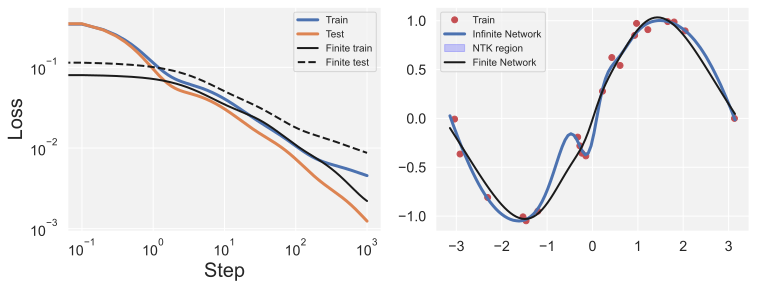

In [21]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, val_scores, 'k-', linewidth=2)
plt.loglog(ts, train_scores, 'k--', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 
        'Finite train', 'Finite test'])

plt.subplot(1, 2, 2)

plt.plot(train_xs, train_ys, 'ro')

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, model2(test_x).cpu().detach().numpy(), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'NTK region', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))